# PPProjecct

In [ ]:
!pip install probaforms -U

## Data

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv('train_cache.csv')
train.head()

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,712511,386627.74,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
1,709311,388112.33,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
2,712464,386384.72,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
3,711226,387053.72,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769
4,710919,387191.78,8,46,6,100,random,read,4+1,24,nvme,0,hse-09142022-013313-z3769


In [ ]:
test = pd.read_csv('test_cache.csv')
test.head()

,iops,lat,block_size,n_jobs,iodepth,read_fraction,load_type,io_type,raid,n_disks,device_type,offset,id
0,21483,613944.00,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
1,21354,610190.00,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
2,20883,613910.75,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
3,21493,610052.62,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065
4,21473,606866.62,256,8,4,45,random,read,4+1,24,nvme,0,hse-09132022-180712-z63065


In [ ]:
pd.unique(train[['block_size']]. values.ravel())

array([  8,  16,  32,  64, 256,   4, 128])

In [ ]:
pd.unique(train[['n_jobs']]. values.ravel()).size

32

In [ ]:
pd.unique(train[['iodepth']]. values.ravel()).size

16

In [ ]:
pd.unique(train[['read_fraction']]. values.ravel()).size

101

In [ ]:
pd.unique(train[['io_type']]. values.ravel())

array(['read', 'write'], dtype=object)

In [ ]:
pd.unique(train[['id']]. values.ravel()).size

408

In [ ]:
test['io_type_num'] = test['io_type'] == 'write'

In [ ]:
test.io_type_num = test.io_type_num.replace({ True : 1 , False : 0 })

In [ ]:
y_test = torch.tensor(test[['iops', 'lat']].values)

In [ ]:
X_test = torch.tensor(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
print(len(y_test), len(X_test))

12120 12120


In [ ]:
train['io_type_num'] = train['io_type'] == 'write'

In [ ]:
train.io_type_num = train.io_type_num.replace({ True : 1 , False : 0 })

In [ ]:
y_tr = torch.tensor(train[['iops', 'lat']].values)

In [ ]:
X_tr = torch.tensor(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

In [ ]:
pd.unique(test[['id']]. values.ravel())

array(['hse-09132022-180712-z63065', 'hse-09132022-212616-z36709',
       'hse-09132022-203942-z36542', 'hse-09132022-113615-z47578',
       'hse-09132022-113127-z92275', 'hse-09132022-202959-z97080',
       'hse-09132022-130756-z72964', 'hse-09132022-152621-z23474',
       'hse-09132022-222402-z67880', 'hse-09142022-002727-z41754',
       'hse-09132022-215503-z42747', 'hse-09132022-154850-z69269',
       'hse-09132022-162550-z13863', 'hse-09132022-131738-z64548',
       'hse-09132022-163352-z28622', 'hse-09132022-203624-z40860',
       'hse-09132022-111214-z18642', 'hse-09132022-230720-z49925',
       'hse-09132022-180046-z99430', 'hse-09132022-162239-z71118',
       'hse-09132022-115719-z1844', 'hse-09132022-130309-z70101',
       'hse-09132022-143919-z2607', 'hse-09132022-191917-z69202',
       'hse-09132022-105038-z85297', 'hse-09132022-125820-z33361',
       'hse-09132022-200733-z61475', 'hse-09132022-174129-z68191',
       'hse-09132022-131108-z11709', 'hse-09132022-221738-z10431

## Graphs

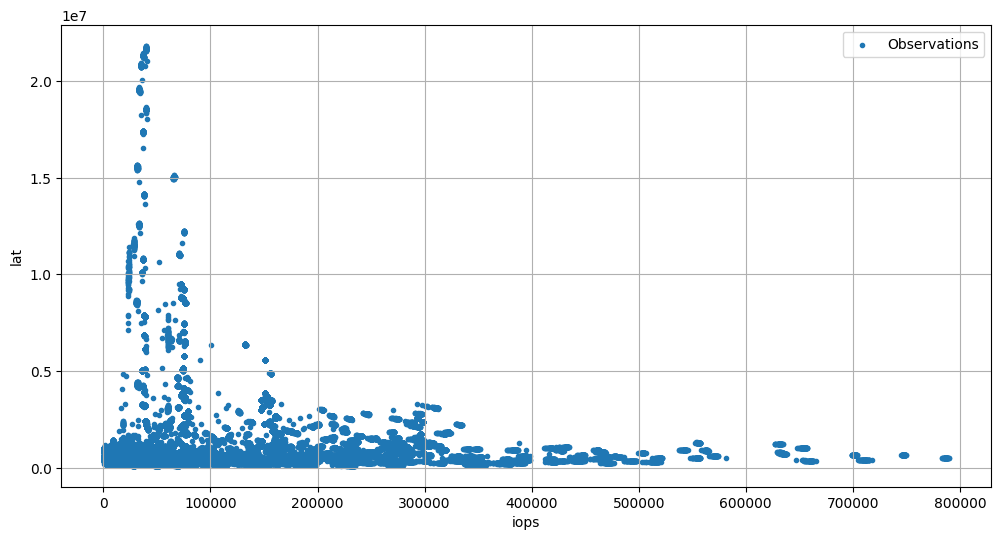

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_tr[:, 0], y_tr[:, 1], marker='.', label='Observations', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

## Scalers

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np
from dataclasses import dataclass

# from https://github.com/HEPML-AnomalyDetection/CATHODE/blob/4e96989296193da18508710afbfa3b37fffe5952/data_handler.py
def logit_transform_inverse(data, datamin, datamax):
    dataout = (datamin + datamax*np.exp(data))/(1 + np.exp(data))
    return dataout

def quick_logit(x, x_min, x_max, eps):
    x_norm = (x-x_min)/(x_max-x_min)
    x_norm = x_norm[((x_norm != 0) & (x_norm != 1)).all(axis=1)]
    x_norm[x_norm == 0] += eps
    x_norm[x_norm == 1] -= eps
    logit = np.log(x_norm/(1-x_norm))
    logit = logit[~np.isnan(logit).any(axis=1)]
    return logit

class LogitScaler(TransformerMixin, BaseEstimator):

    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.x_max = None
        self.x_min = None

    def fit(self, X, y=None):
        self.x_min = np.min(X, axis=0) - self.eps
        self.x_max = np.max(X, axis=0) + self.eps
        return self

    def transform(self, X):
        return quick_logit(X, self.x_min, self.x_max, self.eps)

    def inverse_transform(self, X):
        return logit_transform_inverse(X, self.x_min, self.x_max)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = make_pipeline(LogitScaler(eps=0.1), StandardScaler())

In [ ]:
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
y_test_ss = scaler.transform(test[['iops', 'lat']].values)

<ipython-input-22-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [ ]:
stscaler = StandardScaler()

In [ ]:
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

## Final experiments

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from probaforms.models import RealNVP

In [36]:
train = train
scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())
y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
# y_test_ss = scaler.transform(test[['iops', 'lat']].values)
stscaler = StandardScaler()
X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
# X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)

model = RealNVP(lr=0.001, n_layers=12, n_epochs=100, batch_size=64) # 200
model.fit(y_tr_ss, X_tr_ss) # (target, condition)

### RESULTS

In [37]:
from torch.utils.data import TensorDataset, DataLoader

In [38]:
ids = ['hse-09132022-180712-z63065', 'hse-09132022-203942-z36542', 'hse-09132022-192053-z87989']
ztotal_iops = []
ztotal_lat = []
zgen_iops = []
zgen_lat = []
for i in range(len(ids)):
    y_test = torch.tensor(test[test['id'] == ids[i]][['iops', 'lat']].values)
    X_test = torch.tensor(test[test['id'] == ids[i]][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
    y_test_ss = scaler.transform(y_test)
    X_test_ss = stscaler.transform(X_test)
    y_tst = torch.tensor(y_test_ss, dtype=torch.float32)
    X_tst = torch.tensor(X_test_ss, dtype=torch.float32)
    print(len(y_tst), len(X_tst))
    dataset = TensorDataset(y_tst, X_tst)
    results_iops = []
    results_lat = []
    for i, data in enumerate(DataLoader(dataset)):
        y_data= data[0]
        X_data = data[1]
        for lay in model.nf.layers:
            y_data, _ = lay.f(y_data, X_data)
        # y_data = scaler.inverse_transform(y_data.detach())
        y_data = y_data.detach()
        results_iops.append(y_data[0][0])
        results_lat.append(y_data[0][1])

    y_gen = model.sample(stscaler.transform(X_test.clone().detach()))
    y_gen = torch.tensor(y_gen, dtype=torch.float32)
    dataset = TensorDataset(y_gen, X_tst)
    genresults_iops = []
    genresults_lat = []
    for i, data in enumerate(DataLoader(dataset)):
        y_data= data[0]
        X_data = data[1]
        for lay in model.nf.layers:
            y_data, _ = lay.f(y_data, X_data)
        # y_data = scaler.inverse_transform(y_data.detach())
        y_data = y_data.detach()
        genresults_iops.append(y_data[0][0])
        genresults_lat.append(y_data[0][1])

    ztotal_iops.append(results_iops)
    ztotal_lat.append(results_lat)
    zgen_iops.append(genresults_iops)
    zgen_lat.append(genresults_lat)

<ipython-input-22-a80eb4482932>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  logit = logit[~np.isnan(logit).any(axis=1)]


120 120


<ipython-input-22-a80eb4482932>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  logit = logit[~np.isnan(logit).any(axis=1)]


120 120


<ipython-input-22-a80eb4482932>:16: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  logit = logit[~np.isnan(logit).any(axis=1)]


120 120


In [39]:
# ztotal_iops

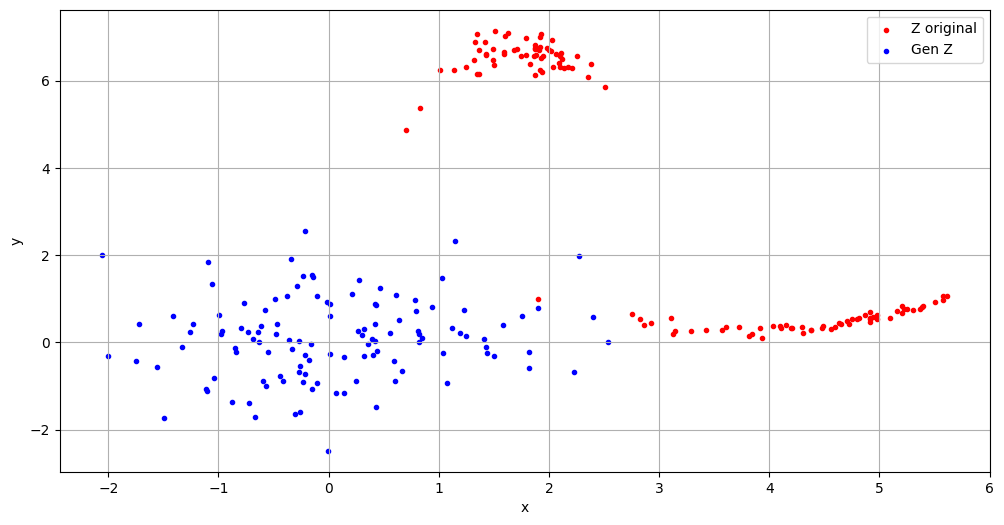

In [40]:
plt.figure(figsize=(12, 6))

plt.scatter(ztotal_iops[0], ztotal_lat[0], marker='.', label='Z original', color='red', linewidth=1)
plt.scatter(zgen_iops[0], zgen_lat[0], marker='.', label='Gen Z', color='blue', linewidth=1)

plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()

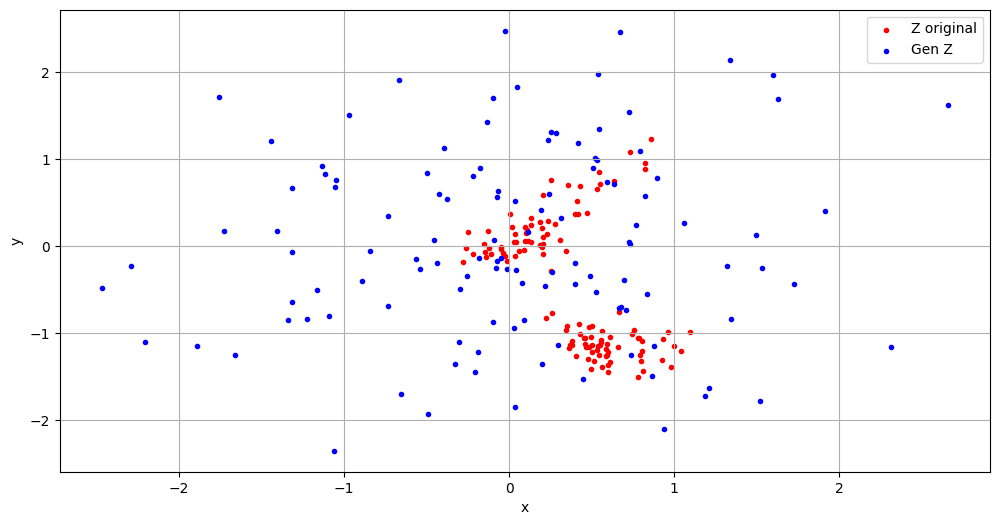

In [41]:
plt.figure(figsize=(12, 6))

plt.scatter(ztotal_iops[1], ztotal_lat[1], marker='.', label='Z original', color='red', linewidth=1)
plt.scatter(zgen_iops[1], zgen_lat[1], marker='.', label='Gen Z', color='blue', linewidth=1)

plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()

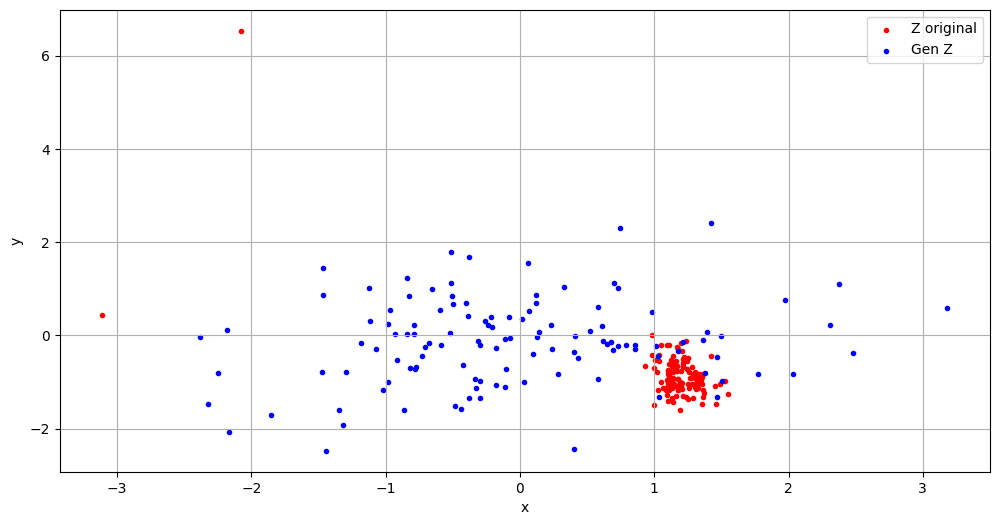

In [42]:
plt.figure(figsize=(12, 6))

plt.scatter(ztotal_iops[2], ztotal_lat[2], marker='.', label='Z original', color='red', linewidth=1)
plt.scatter(zgen_iops[2], zgen_lat[2], marker='.', label='Gen Z', color='blue', linewidth=1)

plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()

проверить типы dataloader' и dtype в тензорах.

Done. сделала через даталоадер

## aaa

это код когда я просто проверяла модельку, запускать не нада

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_new[0], y_new[1], marker='.', label='Observations', linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

In [ ]:
results1 = []
results2 = []
results3 = []
numb = 10 # 10

for i in range(numb):
  print(i)
  ids = pd.unique(train[['id']]. values.ravel())
  id1 = np.array([np.random.sample() for k in range(len(ids))])
  ar = []
  for j in range(len(ids)):
    if id1[j] <= 0.7:
      ar.append(ids[j])
  train = train.loc[train['id'].isin(ar)]
  scaler = make_pipeline(LogitScaler(eps=0.01), StandardScaler())
  y_tr_ss = scaler.fit_transform(train[['iops', 'lat']].values)
  y_test_ss = scaler.transform(test[['iops', 'lat']].values)
  stscaler = StandardScaler()
  X_tr_ss = stscaler.fit_transform(train[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
  X_test_ss = stscaler.transform(test[['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
  # model
  model = RealNVP(lr=0.001, n_layers=24, n_epochs=200, batch_size=64) # 200
  model.fit(y_tr_ss, X_tr_ss) # (target, condition)
  # samples 1
  y_test = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['iops', 'lat']].values)
  X_test = torch.tensor(test[test['id'] == 'hse-09132022-180712-z63065'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
  y_gen = model.sample(stscaler.transform(X_test.clone().detach()))
  y_gen = scaler.inverse_transform(y_gen)
  if i == 0:
    results1.append(y_test)
  results1.append(y_gen)
  # samples 2
  y_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-203942-z36542'][['iops', 'lat']].values)
  X_test_2 = torch.tensor(test[test['id'] == 'hse-09132022-203942-z36542'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
  y_gen_2 = model.sample(stscaler.transform(X_test_2.clone().detach()))
  y_gen_2 = scaler.inverse_transform(y_gen_2)
  if i == 0:
    results2.append(y_test_2)
  results2.append(y_gen_2)
  # samples 3
  y_test_3 = torch.tensor(test[test['id'] == 'hse-09132022-192053-z87989'][['iops', 'lat']].values)
  X_test_3 = torch.tensor(test[test['id'] == 'hse-09132022-192053-z87989'][['block_size', 'n_jobs', 'iodepth', 'read_fraction', 'io_type_num', 'n_disks']].values)
  y_gen_3 = model.sample(stscaler.transform(X_test_3.clone().detach()))
  y_gen_3 = scaler.inverse_transform(y_gen_3)
  if i == 0:
    results3.append(y_test_3)
  results3.append(y_gen_3)

0


<ipython-input-20-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


1


<ipython-input-20-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


2


<ipython-input-20-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


3


<ipython-input-20-a80eb4482932>:15: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm))


In [ ]:
colors = np.array(["blue","red","green","yellow","pink","black","orange","purple","brown","cyan","magenta"])

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(results1[0][:, 0], results1[0][:, 1], marker='.', label='Observations', color=colors[0], linewidth=1)
for i in range(1, numb+1):
  plt.scatter(results1[i][:, 0], results1[i][:, 1], marker='.', label='Generated with NF', color=colors[i], linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(results2[0][:, 0], results2[0][:, 1], marker='.', label='Observations', color=colors[0], linewidth=1)
for i in range(1, numb+1):
  plt.scatter(results2[i][:, 0], results2[i][:, 1], marker='.', label='Generated with NF', color=colors[i], linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(results3[0][:, 0], results3[0][:, 1], marker='.', label='Observations', color=colors[0], linewidth=1)
for i in range(1, numb+1):
  plt.scatter(results3[i][:, 0], results3[i][:, 1], marker='.', label='Generated with NF', color=colors[i], linewidth=1)

plt.xlabel("iops")
plt.ylabel("lat")
plt.grid()
plt.legend()
plt.show()